# Filtering

![Filters](images/Filters.jpeg)

Pairs of mapped read-ends are filtered in order to keep only valid pairs. The filters available in TADbit are these one:
1. __Self-circle__: both read-ends are mapped to the same RE fragment in *opposed* orientation.
2. __Dangling-end__: both read-ends are mapped to the same RE fragment in *facing* orientation.
3. __Error__: both read-ends are mapped to the same RE fragment in the same orientation.
4. __Extra dangling-end__: the read-ends are mapped to different RE fragments in *facing* orientation, but are close enough (< *max_molecule_length* bp) from the RE cut-site to be considered part of adjacent RE fragments that were not separated by digestion. The *max_molecule_length* parameter can be inferred from the *fragment_size* function previously detailed.
5. __Too close from RE sites (or semi-dangling-end)__: the start position of one of the read-end is too close (5 bp by default) from the RE cutting site. 
6. __Too short__: one of the read-ends is mapped to RE fragments of less than 75bp. These are removed since there is ambiguity on where the read-end is mapped as it could also belong to any of the two neighboring RE fragments.
7. __Too large__: the read-ends are mapped to long RE fragments (default: 100 kb, P < 10-5 to occur in a randomized genome) and they likely represent poorly assembled or repetitive regions.
8. __Over-represented__: the read-ends coming from the top 0.5% most frequently detected RE fragments, they may represent PCR artefacts, random breaks, or genome assembly errors. 
9. __PCR artefacts or duplicated__: the combination of the start positions, mapped length, and strands of both read-ends are identical. In this case, only one copy is kept.
10. __Random breaks__: the start position of one read-end is too far (> *minimum_distance_to_RE*) from the RE cut-site. These are produced most probably by non-canonical enzyme activity or by random physical breakage of the chromatin. Note, that to filter all these types of fragments the minimum_distance_to_RE parameter should be larger than the *maximum_fragment_length*.

In [2]:
cell = 'mouse_B'  # or mouse_PSC
rep = 'rep1'  # or rep2

### Filter out dangling ends and self-circles

In [3]:
from pytadbit.mapping.filter import filter_reads

The `max_molecule_length` parameter used to filter-out pseudo-dangling-ends can be extracted from the `insert_size` function in previous section.

The `min_distance_to_re`, that affects the detection of random breaks, should be large enough in order to contain almost all the fragments.

In [4]:
# this will last ~10 minutes
masked = filter_reads(
    'results/fragment/{0}_{1}/03_filtering/reads12_{0}_{1}.tsv'.format(cell, rep), 
    max_molecule_length=750, over_represented=0.005, max_frag_size=100000, 
    min_frag_size=50, re_proximity=5, min_dist_to_re=1000)

Filtered reads (and percentage of total):

                   Mapped both  :   87,862,102 (100.00%)
  -----------------------------------------------------
   1-               self-circle :       87,761 (  0.10%)
   2-              dangling-end :    4,813,620 (  5.48%)
   3-                     error :       18,165 (  0.02%)
   4-        extra dangling-end :   12,933,038 ( 14.72%)
   5-        too close from RES :   21,372,275 ( 24.32%)
   6-                 too short :    3,628,579 (  4.13%)
   7-                 too large :        1,256 (  0.00%)
   8-          over-represented :    2,693,107 (  3.07%)
   9-                duplicated :    1,605,185 (  1.83%)
  10-             random breaks :      308,512 (  0.35%)


This generates a dictionary with the different filters and the reads affected by each.

### Apply filters on the data

In [5]:
from pytadbit.mapping.filter import apply_filter

apply_filter('results/fragment/{0}_{1}/03_filtering/reads12_{0}_{1}.tsv'.format(cell, rep), 
             'results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), masked, 
             filters=[1, 2, 3, 4, 6, 7, 9, 10])

    saving to file 66,612,427 reads without.


66612427

#### Evaluate changes

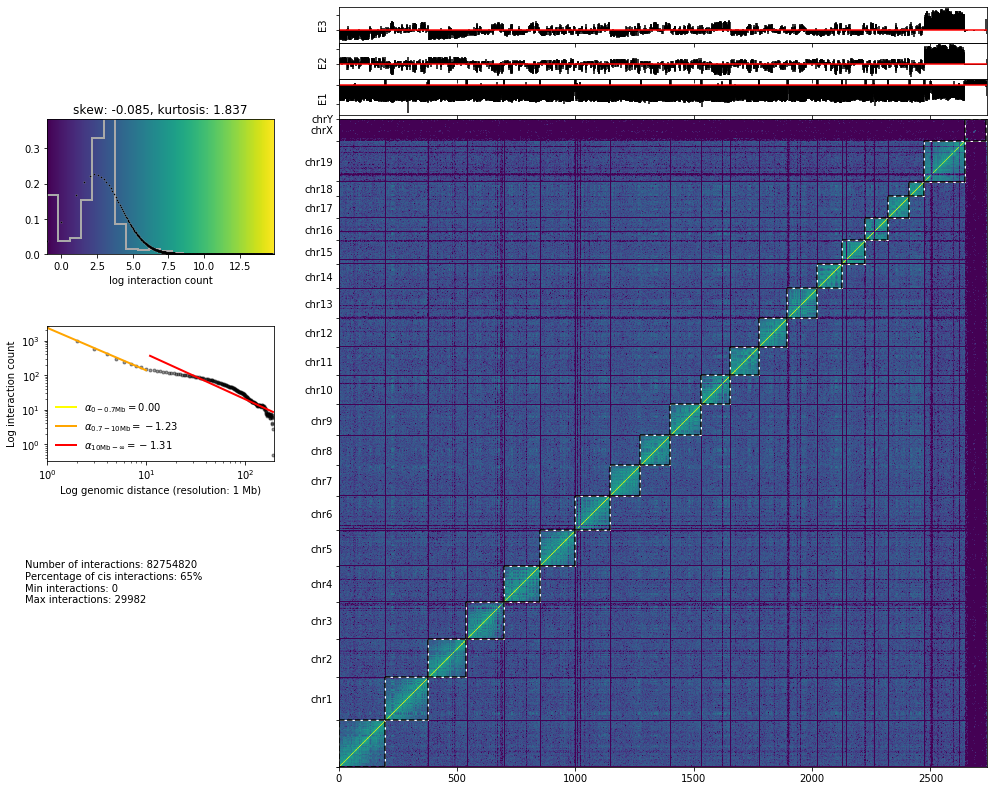

In [6]:
from pytadbit.mapping.analyze import hic_map

hic_map('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
        resolution=1000000, show=True, cmap='viridis')

Zoom to a single chromosome or a region:

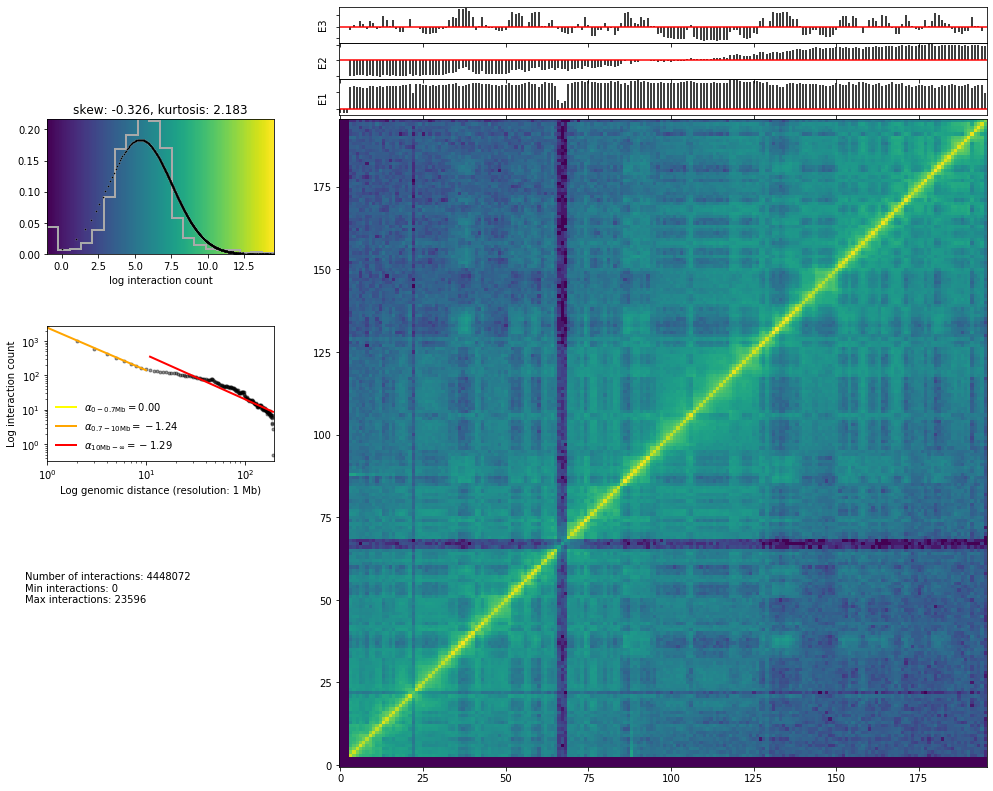

In [7]:
hic_map('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
        resolution=1000000, show=True, focus='chr1', cmap='viridis')

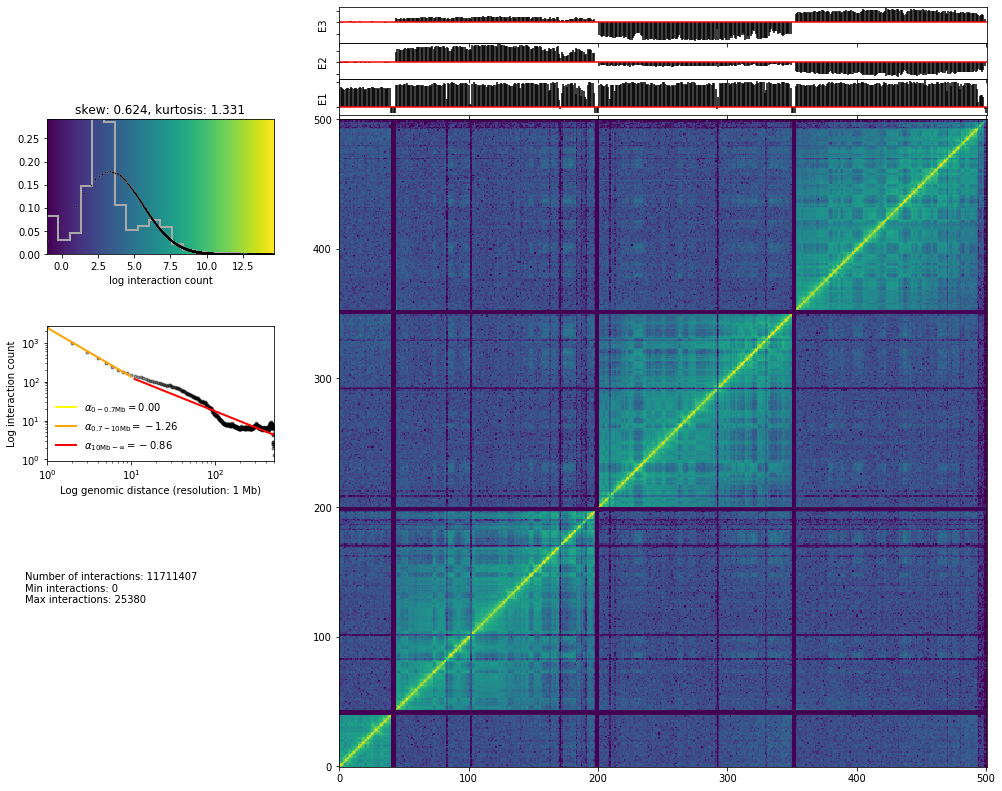

In [8]:
hic_map('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
        resolution=1000000, show=True, focus=(500, 1000), cmap='viridis')

## Save to BAM

Working with TSV (tab-separated-value file format) files is very slow. For the next part of the tutorial we will be using BAM (binary-alignment-map) files, which are compressed and indexed.

__Note__: The fields we use in TADbit to generate a BAM file are not the conventional ones, we modify them as follows to store only the necessary information for the remaining part of the analysis:
 - Read ID (same as in the original FASTQ file)
 - Flag (binary mask for the application of the 10 filters previously described):
   1. self-circle
   2. dangling-end
   3. error
   4. extra dangling-end
   5. too close from RES
   6. too short
   7. too large
   8. over-represented
   9. duplicated
   10. random breaks
   11. inter-chromosomal
   
   For example if we want to keep only pairs of read-ends that are excelusively inter-fragment contacts and that are not duplicated, we would apply filters 1, 2, 3 (self-circle, dangling-ends, errors) and 9 (duplicated) resulting in a binary number like this: 00100000111 which translates in decimal: 263. We could thus obtain these read-pairs with `samtools view -F 263`.
 - Chromosome ID of the first read-end
 - Genomic position of the first read-end
 - MAPQ set to 0
 - Pseudo CIGAR replaced by the mapped length of the first read-end, and information about current copy (each pair is present twice in the BAM, P: first copy, S: second copy)
 - Chromosome ID of the second read-end
 - Genomic position of the second read-end
 - Mapped length of the second pair-end
 - Nothing (*) (the field is usually reserved to sequence)
 - Nothing (*) (the field is usually reserved to quality)
 - TC tag indicating single (1) or multi contact (3 6 ... number being the number of times a given sequenced fragment is involved in a pairwise contact)
 - S1 and S2 tags are the strand orientation of the left and right read-end


In [9]:
from pytadbit.parsers.hic_bam_parser import bed2D_to_BAMhic

In [10]:
bed2D_to_BAMhic('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.tsv'.format(cell, rep), 
                valid=True, ncpus=8, 
                outbam='results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}'.format(cell, rep), 
                frmt='mid', masked=None)